## Telecom - project objective:

 - Learn to predict customer churn for the telecommunications operator "Niyeдиногоразрыва.com". 
 
 - If it turns out that a user is planning to leave, offer them promo codes and special conditions.

### Description of services

<b>The operator provides two main types of services:</b> 

1. Fixed-line telephone communication. It is possible to connect a telephone set to multiple lines simultaneously.
2. Internet. Connection can be of two types: through a telephone line (DSL, which stands for "digital subscriber line") or fiber optic cable (Fiber optic).

<b>In addition, the following services are also available:</b>

- Internet security: antivirus (DeviceProtection) and blocking of unsafe websites (OnlineSecurity);
- Dedicated technical support line (TechSupport);
- Cloud storage for data backup (OnlineBackup);
- Streaming TV (StreamingTV) and movie catalog (StreamingMovies).

<b>Customers can pay for services each month or sign a contract for 1-2 years. Various payment methods are available.</b>


The data consists of files obtained from different sources:

- `contract.csv` — contract information;
- `personal.csv` — customer personal data;
- `internet.csv` —  information about internet services;
- `phone.csv` — information about telephone services.

In all files, the `customerID` column contains the customer code.

The contract information is valid as of <b>February 1, 2020.</b>

### Exploring the general data.

In [1]:
!pip install phik
!pip install category_encoders
!pip install -U scikit-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from phik import resources, report
from phik.binning import bin_data

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, make_scorer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    telecom_contact = pd.read_csv(r"C:\Users\natal\OneDrive\Рабочий стол\telecom\final_provider\contract.csv")
    telecom_internet = pd.read_csv(r"C:\Users\natal\OneDrive\Рабочий стол\telecom\final_provider\internet.csv")
    telecom_personal = pd.read_csv(r"C:\Users\natal\OneDrive\Рабочий стол\telecom\final_provider\personal.csv")
    telecom_phone = pd.read_csv(r"C:\Users\natal\OneDrive\Рабочий стол\telecom\final_provider\phone.csv")

except:
    telecom_contact = pd.read_csv("/datasets/final_provider/contract.csv")
    telecom_internet = pd.read_csv("/datasets/final_provider/internet.csv")
    telecom_personal = pd.read_csv("/datasets/final_provider/personal.csv")
    telecom_phone = pd.read_csv("/datasets/final_provider/phone.csv")   

In [4]:
telecom_contact.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
telecom_contact.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5685,4475-NVTLU,2016-05-01,No,Two year,No,Electronic check,19.20,903.7
6594,8317-BVKSO,2018-12-01,No,Month-to-month,Yes,Electronic check,20.05,299.3
6810,7758-XKCBS,2018-08-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,29.70,438.25
1355,5624-RYAMH,2019-05-01,No,Month-to-month,Yes,Electronic check,19.50,178.85
5516,6923-EFPNL,2019-08-01,2019-12-01 00:00:00,Month-to-month,No,Credit card (automatic),51.75,201.1
3283,1085-LDWAM,2014-05-01,No,One year,Yes,Credit card (automatic),20.35,1442.65
2825,7610-TVOPG,2018-11-01,No,Month-to-month,Yes,Electronic check,26.35,378.6
4755,8849-AYPTR,2017-05-01,No,Month-to-month,No,Electronic check,91.25,2964.05
1689,0274-JKUJR,2019-07-01,No,Month-to-month,No,Mailed check,58.85,465.7
4690,7036-ZZKBD,2017-07-01,No,Month-to-month,Yes,Credit card (automatic),66.40,2019.8


In [6]:
telecom_contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


<b>!TotalCharges      7043 non-null   object </b>

In [7]:
telecom_contact.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [8]:
telecom_contact.duplicated().sum()

0

In [9]:
telecom_contact.notnull().sum()

customerID          7043
BeginDate           7043
EndDate             7043
Type                7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7043
dtype: int64

In [10]:
telecom_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [11]:
telecom_internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
839,7013-PSXHK,DSL,No,No,Yes,Yes,Yes,Yes
1286,2929-QNSRW,Fiber optic,No,Yes,No,No,Yes,Yes
43,2954-PIBKO,DSL,Yes,No,Yes,Yes,No,No
2216,3999-QGRJH,Fiber optic,No,No,No,No,No,No
926,0135-NMXAP,Fiber optic,No,Yes,No,No,Yes,No
4995,2101-RANCD,Fiber optic,No,No,No,No,No,No
5421,6502-MJQAE,Fiber optic,No,No,No,No,No,No
1868,6650-BWFRT,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1195,5724-BIDBU,DSL,Yes,No,No,No,No,No
4667,0239-OXEXL,Fiber optic,Yes,Yes,No,No,No,No


In [12]:
telecom_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
telecom_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [14]:
telecom_internet.duplicated().sum()

0

In [15]:
telecom_internet.notnull().sum()

customerID          5517
InternetService     5517
OnlineSecurity      5517
OnlineBackup        5517
DeviceProtection    5517
TechSupport         5517
StreamingTV         5517
StreamingMovies     5517
dtype: int64

In [16]:
telecom_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [17]:
telecom_personal.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
117,5299-RULOA,Female,0,Yes,Yes
5407,9786-YWNHU,Female,0,Yes,Yes
254,3675-YDUPJ,Male,0,No,No
1680,5451-MHQOF,Male,0,Yes,Yes
1619,5930-GBIWP,Male,0,No,No
5886,1709-EJDOX,Female,0,Yes,Yes
1898,6689-TCZHQ,Female,1,No,No
6827,1036-GUDCL,Male,0,Yes,Yes
1348,1184-PJVDB,Male,0,Yes,No
1033,2632-TACXW,Female,0,Yes,No


In [18]:
telecom_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
telecom_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [20]:
telecom_personal.duplicated().sum()

0

In [21]:
telecom_personal.notnull().sum()

customerID       7043
gender           7043
SeniorCitizen    7043
Partner          7043
Dependents       7043
dtype: int64

In [22]:
telecom_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [23]:
telecom_phone.sample(10)

,customerID,MultipleLines
2190,5136-KCKGI,Yes
4474,6075-QMNRR,No
2122,6463-HHXJR,Yes
3659,5863-OOKCL,No
1794,3723-BFBGR,Yes
3599,7225-CBZPL,Yes
5354,8277-RVRSV,Yes
6141,1047-RNXZV,No
2377,2262-SLNVK,No
5444,9503-XJUME,No


In [24]:
telecom_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [25]:
telecom_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [26]:
telecom_phone.duplicated().sum()

0

In [27]:
telecom_phone.notnull().sum()

customerID       6361
MultipleLines    6361
dtype: int64

<b>Summary:</b> At first glance, the TotalCharges column in the telecom_contract table has an object data type, which may indicate that it contains non-numeric values that need to be converted to numeric values. The time format in the BeginDate and EndDate columns should also be changed. It can also be said that the number of rows in the tables differs.

### Data preparation

In [28]:
#Let's merge the tables.
telecom_contact = telecom_contact.set_index('customerID')
telecom_internet = telecom_internet.set_index('customerID')
telecom_personal = telecom_personal.set_index('customerID')
telecom_phone = telecom_phone.set_index('customerID')

In [29]:
telecom = telecom_contact.join([telecom_internet, telecom_personal, telecom_phone])
telecom.sample(20)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
6869-FGJJC,2014-06-01,No,One year,No,Credit card (automatic),79.60,5461.45,Fiber optic,No,Yes,Yes,No,No,No,Male,0,No,No,No
2091-RFFBA,2017-06-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.90,2217.15,Fiber optic,No,No,No,No,No,No,Female,1,No,No,Yes
1813-JLKWR,2014-10-01,No,One year,No,Bank transfer (automatic),19.80,1336.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
1074-AMIOH,2015-09-01,No,Month-to-month,Yes,Bank transfer (automatic),108.25,5935.1,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,No
2346-CZYIL,2017-11-01,No,Two year,No,Credit card (automatic),20.35,531.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
8096-LOIST,2018-07-01,No,Month-to-month,Yes,Electronic check,56.20,1093.4,DSL,No,No,No,No,No,Yes,Female,0,No,No,No
9848-JQJTX,2014-02-01,No,Two year,Yes,Bank transfer (automatic),100.90,7459.05,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,0,No,No,Yes
0177-PXBAT,2017-05-01,No,Month-to-month,Yes,Bank transfer (automatic),109.90,3694.7,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,1,Yes,No,Yes
6137-MFAJN,2016-02-01,No,Month-to-month,Yes,Electronic check,44.80,2104.55,DSL,Yes,Yes,No,No,Yes,No,Female,0,No,No,NaN


In [30]:
telecom.describe()

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


In [31]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null 

In [32]:
telecom.duplicated().sum()

13

In [33]:
telecom.isnull().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

<b>After merging the tables, we have missing values and duplicates.</b>

telecom_contact['TotalCharges'] = telecom_contact['TotalCharges'].astype('float64')

ValueError: could not convert string to float: ''

In [34]:
telecom['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [35]:
#If a customer did not provide information about the internet service, it may be because they are not using this service. Therefore, we can replace the missing values with 'No'.
telecom['InternetService'] = telecom['InternetService'].fillna('No')

In [36]:
telecom.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines'],
      dtype='object')

Most likely, the missing values in these columns may indicate that the services were not connected. Therefore, to fill in the missing values, it was decided to replace them with the string 'No'.

In [37]:
new  = ['OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies',
       'MultipleLines']
telecom[new] = telecom[new].fillna('No')

In [38]:
#will convert the time to the format we need.
telecom['BeginDate'] = pd.to_datetime(telecom['BeginDate'], format='%Y-%m-%d')

In [39]:
telecom['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [40]:
def client_left(EndDate):
    if EndDate == 'No':
        return 'No'
    if EndDate != 'No':
        return 'Yes'
telecom['ClientLeft'] = telecom['EndDate'].apply(client_left)    

In [41]:
telecom[telecom['TotalCharges'] == ' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,ClientLeft
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,No,No
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,No,No,No,No,No,No,No,Male,0,No,Yes,No,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes,No
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,No,No
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,No,No,No,No,No,No,No,Male,0,Yes,Yes,No,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes,No
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,No,No,No,No,No,No,No,Female,0,Yes,Yes,No,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,No,No,No,No,No,No,No,Male,0,Yes,Yes,No,No


In [42]:
#We can see that all date values are the same (2020-02-01), so we can drop them as they don't provide any useful information.
telecom['TotalCharges'] = telecom['TotalCharges'].replace(" ", 0).astype('float32')

In [43]:
#will add a new column "HasEndDate"
telecom['HasEndDate'] = (telecom['EndDate'] != 'No')
telecom['HasEndDate'] 

customerID
7590-VHVEG    False
5575-GNVDE    False
3668-QPYBK     True
7795-CFOCW    False
9237-HQITU     True
              ...  
6840-RESVB    False
2234-XADUH    False
4801-JZAZL    False
8361-LTMKD     True
3186-AJIEK    False
Name: HasEndDate, Length: 7043, dtype: bool

As the information is up to date as of February 1, 2020, let's replace all No values in EndDate with this date. We will use these derived columns for data analysis.

In [44]:
telecom['EndDate'] = telecom['EndDate'].replace('No', '2020-02-01 00:00:00')
telecom['EndDate'] = pd.to_datetime(telecom['EndDate'], format='%Y-%m-%d')

In [45]:
telecom['BeginMonth'] = pd.DatetimeIndex(telecom['BeginDate']).month

telecom['BeginYear'] = pd.DatetimeIndex(telecom['BeginDate']).year

telecom['UsingDays'] = (pd.to_datetime(telecom['EndDate']) - pd.to_datetime(telecom['BeginDate'])).dt.days


In [46]:
telecom = telecom.rename(columns={'gender':'Gender'})

In [47]:
telecom.sample(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,ClientLeft,HasEndDate,BeginMonth,BeginYear,UsingDays
customerID,,,,,,,,,,,,,,,,,,,,,
5649-VUKMC,2018-12-01,2019-12-01,One year,No,Mailed check,95.50,1115.150024,Fiber optic,No,No,...,Female,0,No,No,No,Yes,True,12,2018,365
6732-FZUGP,2016-03-01,2020-02-01,One year,No,Credit card (automatic),94.90,4615.250000,Fiber optic,Yes,No,...,Female,0,No,No,Yes,No,False,3,2016,1432
5572-ZDXHY,2018-02-01,2019-12-01,Month-to-month,Yes,Mailed check,84.30,1855.650024,Fiber optic,No,Yes,...,Female,0,No,No,No,Yes,True,2,2018,668
5325-UWTWJ,2017-07-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),90.55,2929.750000,Fiber optic,Yes,Yes,...,Male,0,Yes,No,Yes,No,False,7,2017,945
9921-QFQUL,2018-03-01,2020-02-01,Month-to-month,No,Mailed check,90.15,2044.949951,Fiber optic,No,No,...,Female,0,Yes,No,Yes,No,False,3,2018,702
9565-DJPIB,2019-06-01,2019-10-01,Month-to-month,No,Mailed check,89.60,365.649994,Fiber optic,No,Yes,...,Female,0,No,Yes,Yes,Yes,True,6,2019,122
9603-OAIHC,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,70.05,70.050003,Fiber optic,No,No,...,Male,1,No,No,No,No,False,1,2020,31
4566-NECEV,2019-09-01,2020-02-01,Month-to-month,No,Electronic check,96.55,500.100006,Fiber optic,No,Yes,...,Male,0,No,No,Yes,No,False,9,2019,153
8314-DPQHL,2019-05-01,2020-02-01,One year,No,Mailed check,50.80,463.600006,DSL,Yes,No,...,Male,0,No,No,No,No,False,5,2019,276


In [48]:
#Delete BeginDate и EndDate
telecom = telecom.drop(['BeginDate','EndDate'], axis=1)
telecom.sample(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,ClientLeft,HasEndDate,BeginMonth,BeginYear,UsingDays
customerID,,,,,,,,,,,,,,,,,,,,,
6862-CQUMB,Month-to-month,Yes,Credit card (automatic),96.10,3646.800049,Fiber optic,No,Yes,No,No,...,Male,0,No,No,No,No,False,1,2017,1126
0486-LGCCH,Two year,No,Mailed check,19.65,225.750000,No,No,No,No,No,...,Male,0,Yes,Yes,No,No,False,3,2019,337
6919-ELBGL,Two year,Yes,Bank transfer (automatic),114.95,8196.400391,Fiber optic,Yes,Yes,Yes,Yes,...,Male,1,Yes,Yes,Yes,No,False,2,2014,2191
0380-ZCSBI,Month-to-month,No,Credit card (automatic),20.00,198.699997,No,No,No,No,No,...,Male,0,No,No,No,No,False,4,2019,306
3567-PQTSO,One year,Yes,Electronic check,105.25,5576.299805,Fiber optic,No,Yes,Yes,No,...,Male,0,Yes,Yes,Yes,No,False,9,2015,1614


In [49]:
telecom.isnull().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
ClientLeft          0
HasEndDate          0
BeginMonth          0
BeginYear           0
UsingDays           0
dtype: int64

### Exploratory Data Analysis 

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'BeginMonth', 'BeginYear', 'UsingDays']


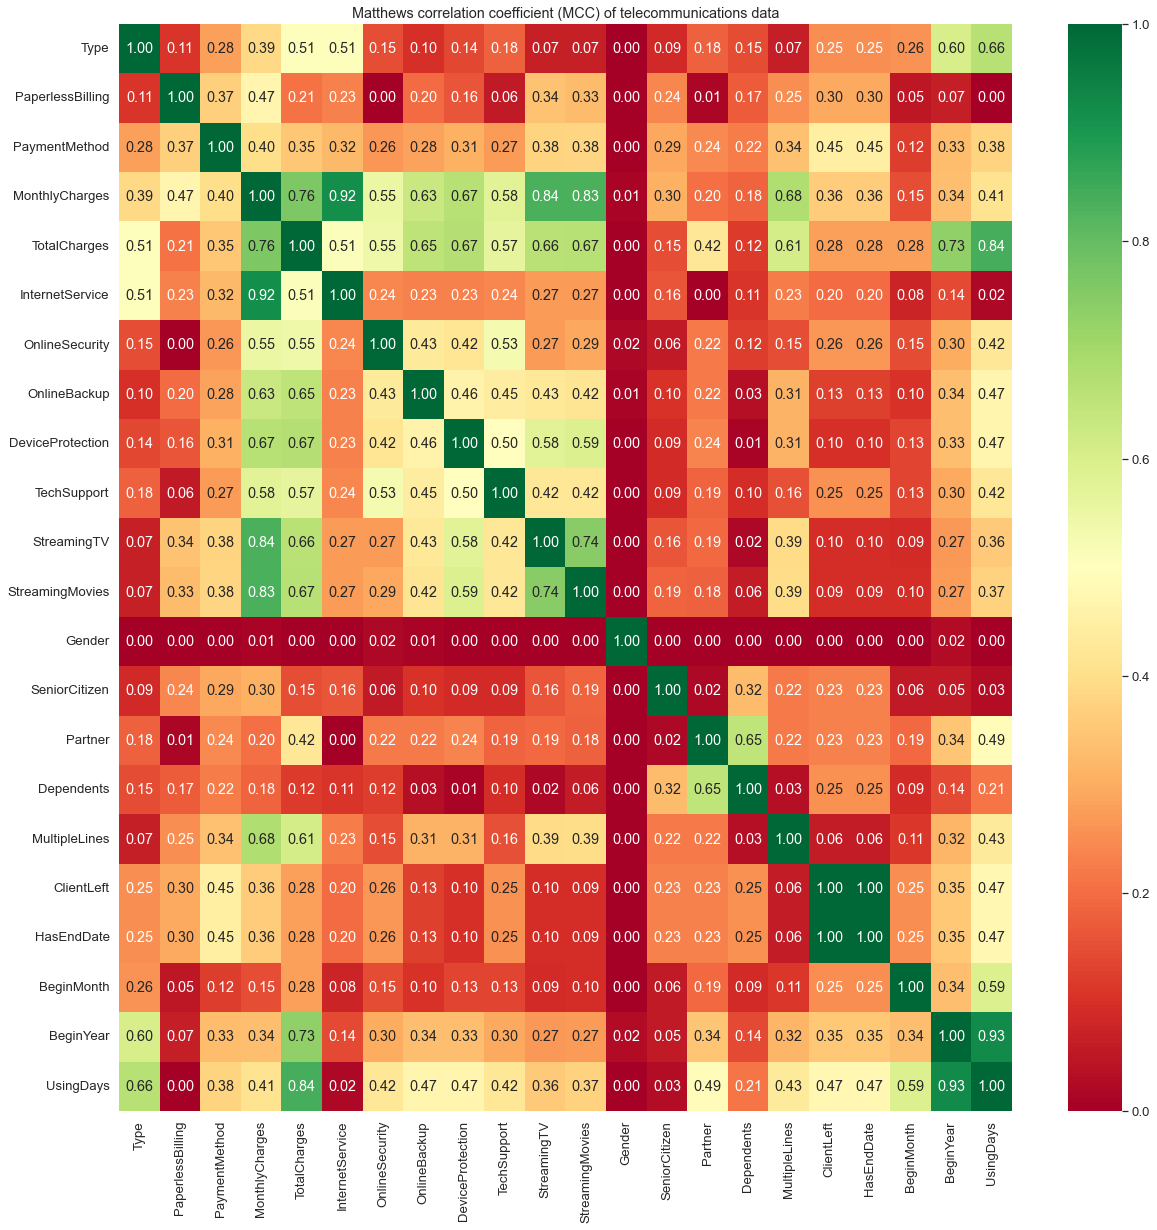

In [50]:
#Matthews correlation coefficient (MCC)
correlations = telecom.phik_matrix()

sns.set(font_scale=1.2)
plt.figure(figsize=(20,20))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Matthews correlation coefficient (MCC) of telecommunications data')
plt.show()

<b> 
The strongest positive correlation (0.933) is observed between Type and BeginYear, which may indicate a certain pattern in the dynamics of these variables.

Another strong positive correlation (0.850) is observed between TotalCharges and ClientLeft/HasEndDate, which may suggest that customers with high total charges are more likely to terminate their contract.

There are strong positive correlations between different internet and streaming services, which is expected as users are likely to choose multiple services.

There is a weak positive correlation between PaperlessBilling and Type, which may mean that users who signed up for a certain type of contract are more likely to opt out of paper bills.

There is a strong negative correlation (-0.678) between ClientLeft and HasEndDate, which may be related to the fact that customers who have not yet completed their contract are unlikely to terminate it.

Some variables have zero correlation with each other (for example, Gender and OnlineSecurity), which may indicate the absence of a relationship between these variables.

There is a strong positive correlation between OnlineSecurity and OnlineBackup, as well as between DeviceProtection and StreamingMovies/StreamingTV, which may indicate that customers using certain services may be inclined to use other services.

There is a strong positive correlation between Partner and Dependents, which means that customers who have a partner are likely to have dependents.</b>

In [51]:
corr_matrix = telecom.corr()
corr_table = corr_matrix.style.background_gradient('RdYlGn')
corr_table.set_caption('Telecom Data Correlation Matrix')
display(corr_table)

,MonthlyCharges,TotalCharges,SeniorCitizen,HasEndDate,BeginMonth,BeginYear,UsingDays
MonthlyCharges,1.000000,0.651174,0.220173,0.193356,-0.018072,-0.264251,0.247754
TotalCharges,0.651174,1.000000,0.103006,-0.198324,-0.194289,-0.819539,0.826109
SeniorCitizen,0.220173,0.103006,1.000000,0.150889,0.029381,-0.028418,0.016514
HasEndDate,0.193356,-0.198324,0.150889,1.000000,0.181417,0.291621,-0.352673
BeginMonth,-0.018072,-0.194289,0.029381,0.181417,1.000000,0.081542,-0.230318
BeginYear,-0.264251,-0.819539,-0.028418,0.291621,0.081542,1.000000,-0.987411
UsingDays,0.247754,0.826109,0.016514,-0.352673,-0.230318,-0.987411,1.000000


<b>Conclusions:</b>

There is a high correlation between MonthlyCharges and TotalCharges, which is quite logical, as the more a customer pays for services, the higher their total payment amount will be.

There is also a strong negative correlation between BeginYear and UsingDays, which is also logical, as the longer a customer uses the telecom services, the older their contract becomes.

SeniorCitizen and HasEndDate have weak correlations with other features, which may mean that they do not strongly influence other variables.

BeginMonth has weak correlations with other features, which may mean that the month the contract began does not have a significant impact on other variables.

UsingDays has a strong correlation with TotalCharges, which may mean that the duration of using the telecom services can affect the total payment amount.

In [52]:
telecom['ClientLeft'].value_counts()

No     5174
Yes    1869
Name: ClientLeft, dtype: int64

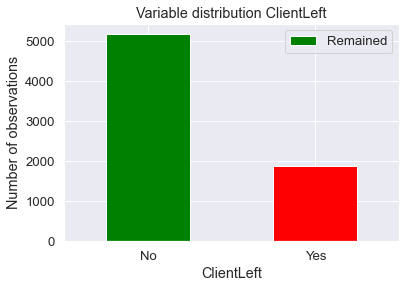

In [53]:
plt.figsize=(5,5)
ax = telecom['ClientLeft'].value_counts().plot(kind='bar', color =['green', 'red'])
plt.title('Variable distribution ClientLeft')
plt.xlabel('ClientLeft')
plt.ylabel('Number of observations')
plt.xticks(rotation=0)
plt.legend(labels=['Remained',' Left'])
plt.show()

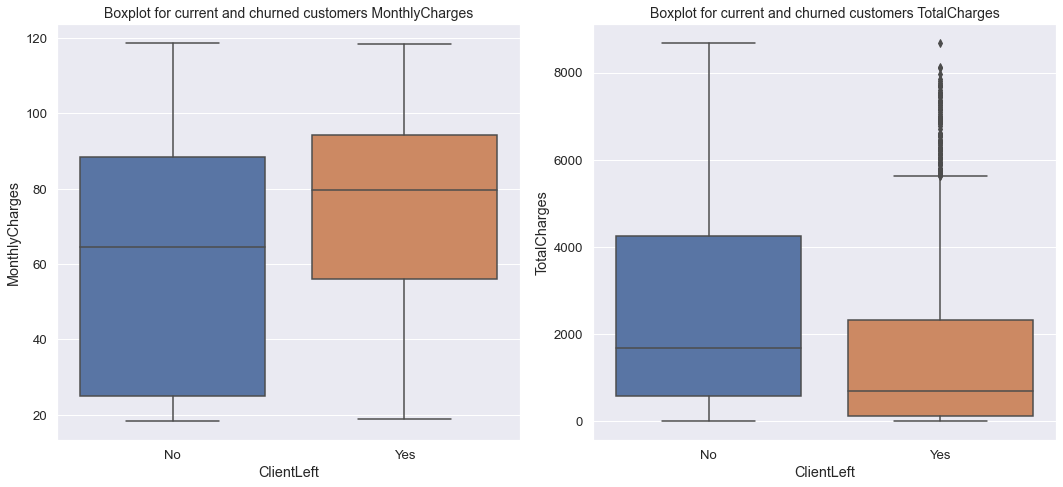

In [63]:
fig,axs = plt.subplots(ncols=2,figsize=(15,7))

sns.boxplot(x ='ClientLeft', y ='MonthlyCharges', data = telecom, ax=axs[0])
axs[0].set_title('Boxplot for current and churned customers MonthlyCharges', fontsize = 14)
sns.boxplot(x='ClientLeft', y='TotalCharges', data=telecom, ax=axs[1])
axs[1].set_title('Boxplot for current and churned customers TotalCharges', fontsize=14)
plt.tight_layout()
plt.show()

In [64]:
telecom1 = telecom[telecom['ClientLeft'] == 'No'][['MonthlyCharges', 'TotalCharges']].describe()
telecom2 = telecom[telecom['ClientLeft'] == 'Yes'][['MonthlyCharges', 'TotalCharges']].describe()

telecom3 = pd.concat([telecom1, telecom2], axis=1, keys=['Stay', 'Left'])
telecom3

Stay                        Left             
      MonthlyCharges TotalCharges MonthlyCharges TotalCharges
count    5174.000000  5174.000000    1869.000000  1869.000000
mean       61.265124  2549.911377      74.441332  1531.796143
std        31.092648  2329.952148      24.666053  1890.823242
min        18.250000     0.000000      18.850000    18.850000
25%        25.100000   572.899979      56.150000   134.500000
50%        64.425000  1679.525024      79.650000   703.549988
75%        88.400000  4262.849976      94.200000  2331.300049
max       118.750000  8672.450195     118.350000  8684.799805

<b>
As a result of the data analysis, we found that among customers who continue to use the company's services, the average monthly payment is $ 61.27 . 

Among customers who left the company, the average monthly payment is $ 74.44 . Additionally, we learned that the average total payment among customers who left the company is significantly lower than among customers who continue to use the company's services. These results can be useful for making decisions aimed at retaining customers.
</b>

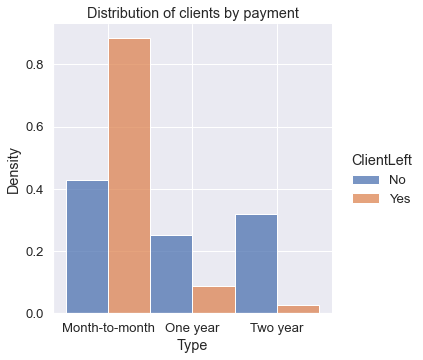

In [65]:
sns.displot(data=telecom, x="Type", hue='ClientLeft', multiple='dodge', stat='density', common_norm=False)
plt.title('Distribution of clients by payment')
plt.show()

<b>It is possible that customers who pay for telecommunication services on a monthly basis are more likely to terminate their contracts, despite the quality of the service provided. Perhaps this is due to the fact that customers who have paid for services for a year or two in advance do not want to lose the prepaid money and therefore continue to use the company's services, even if the quality of the service is unsatisfactory.</b>

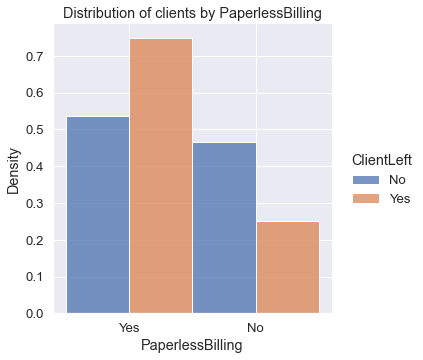

In [66]:
sns.displot(data=telecom, x="PaperlessBilling", hue='ClientLeft', multiple='dodge', stat='density', common_norm=False)
plt.title('Distribution of clients by PaperlessBilling')
plt.show()

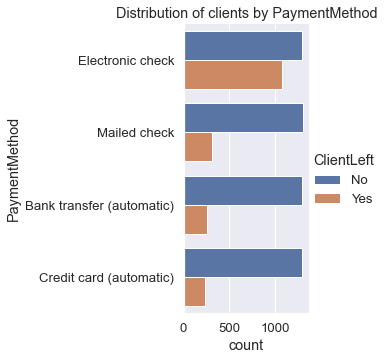

In [68]:
sns.catplot(data=telecom, y="PaymentMethod", hue='ClientLeft', kind='count', dodge=True)
plt.title('Distribution of clients by PaymentMethod')
plt.show()

The data analysis showed that the preferred payment option among customers is the use of electronic check. However, an interesting fact is that this group of customers is characterized by a high level of churn.

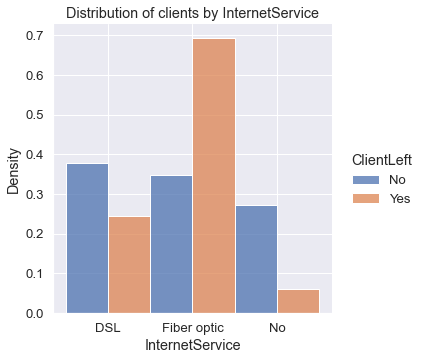

In [69]:
sns.displot(data=telecom, x="InternetService", hue='ClientLeft', multiple='dodge', stat='density', common_norm=False)
plt.title('Distribution of clients by InternetService')
plt.show()

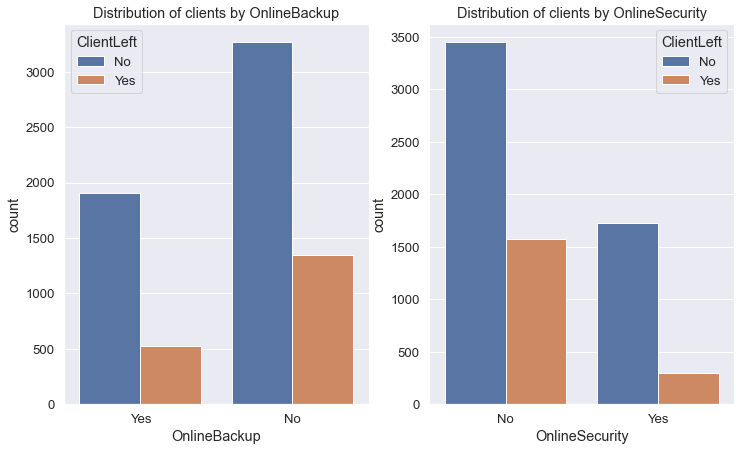

In [70]:
fig,axes = plt.subplots(ncols=2,figsize=(12,7))

sns.countplot(data=telecom, x ='OnlineBackup', hue='ClientLeft', ax=axes[0])
axes[0].set_title('Distribution of clients by OnlineBackup')

sns.countplot(data=telecom, x ='OnlineSecurity', hue='ClientLeft', ax=axes[1])
axes[1].set_title('Distribution of clients by OnlineSecurity')
plt.show()

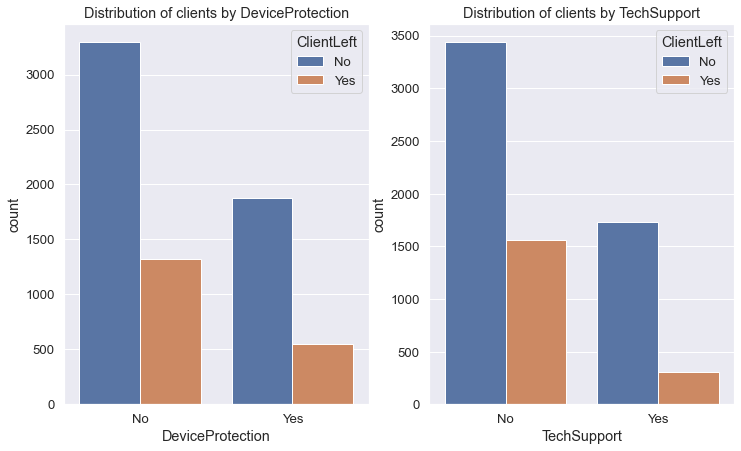

In [71]:
fig,axes = plt.subplots(ncols=2,figsize=(12,7))

sns.countplot(data=telecom, x ='DeviceProtection', hue='ClientLeft', ax=axes[0])
axes[0].set_title('Distribution of clients by DeviceProtection')

sns.countplot(data=telecom, x ='TechSupport', hue='ClientLeft', ax=axes[1])
axes[1].set_title('Distribution of clients by TechSupport')
plt.show()

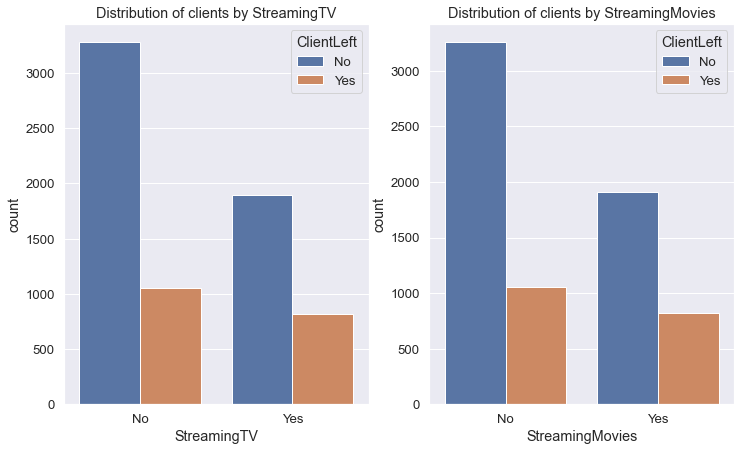

In [72]:
fig,axes = plt.subplots(ncols=2,figsize=(12,7))

sns.countplot(data=telecom, x ='StreamingTV', hue='ClientLeft', ax=axes[0])
axes[0].set_title('Distribution of clients by StreamingTV')

sns.countplot(data=telecom, x ='StreamingMovies', hue='ClientLeft', ax=axes[1])
axes[1].set_title('Distribution of clients by StreamingMovies')
plt.show()

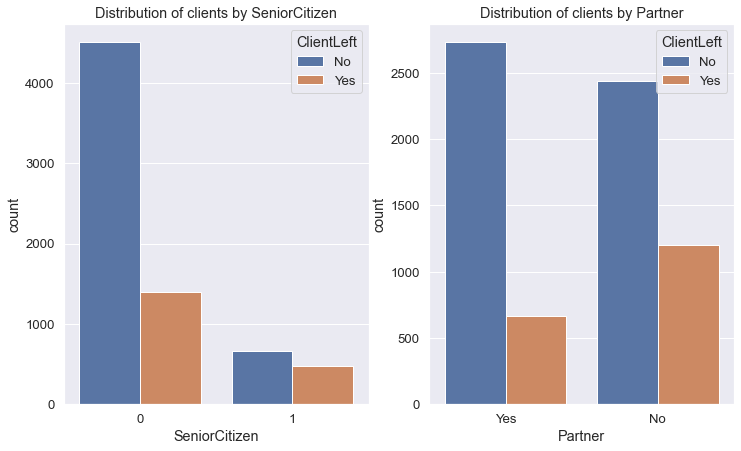

In [73]:
fig,axes = plt.subplots(ncols=2,figsize=(12,7))

sns.countplot(data=telecom, x ='SeniorCitizen', hue='ClientLeft', ax=axes[0])
axes[0].set_title('Distribution of clients by SeniorCitizen')

sns.countplot(data=telecom, x ='Partner', hue='ClientLeft', ax=axes[1])
axes[1].set_title('Distribution of clients by Partner')
plt.show()

There is a significantly smaller number of elderly customers compared to the younger generation. In addition, customers without a partner have a higher tendency to terminate their contract.

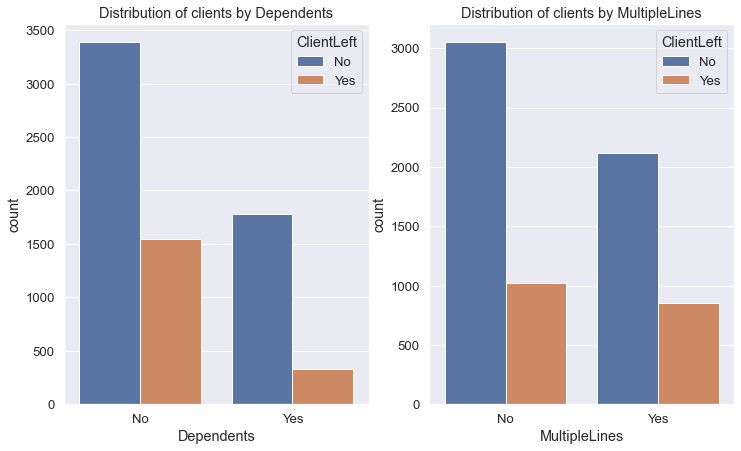

In [74]:
fig,axes = plt.subplots(ncols=2,figsize=(12,7))

sns.countplot(data=telecom, x ='Dependents', hue='ClientLeft', ax=axes[0])
axes[0].set_title('Distribution of clients by Dependents')

sns.countplot(data=telecom, x ='MultipleLines', hue='ClientLeft', ax=axes[1])
axes[1].set_title('Distribution of clients by MultipleLines')
plt.show()

sns.displot(data=telecom, x="BeginMonth", hue='ClientLeft', multiple='dodge', stat='density', common_norm=False)
plt.title('Распределение  клиентов по BeginMonth')
plt.show()

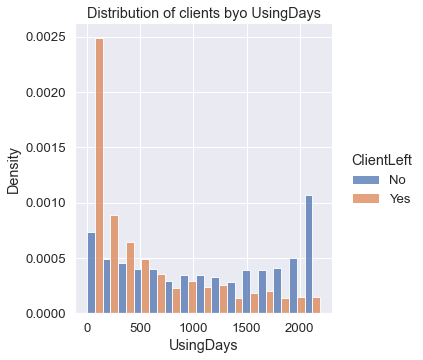

In [75]:
sns.displot(data=telecom, x="UsingDays", hue='ClientLeft', multiple='dodge', stat='density', common_norm=False)
plt.title('Distribution of clients byо UsingDays')
plt.show()

The chart demonstrates that in the first few months, many customers terminate their contracts, but over time, the number of such cases decreases. This means that over time, the ratio of the number of customers who continue to use the company's services to those who terminate their contracts increases.

In [76]:
telecom.drop(['Gender', 'BeginYear', 'BeginMonth','HasEndDate'], axis=1, inplace=True)
telecom.sample(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,ClientLeft,UsingDays
customerID,,,,,,,,,,,,,,,,,,
9851-QXEEQ,Month-to-month,Yes,Electronic check,104.70,4346.399902,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,No,No,Yes,Yes,1248
3440-JPSCL,Month-to-month,Yes,Mailed check,99.95,547.650024,Fiber optic,No,No,Yes,Yes,Yes,Yes,0,No,No,No,Yes,184
3351-NGXYI,Month-to-month,Yes,Electronic check,54.10,889.000000,DSL,Yes,No,No,No,No,No,1,No,No,Yes,No,488
7923-IYJWY,Two year,Yes,Credit card (automatic),116.10,7839.850098,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,1,No,No,Yes,No,2041
4074-SJFFA,Month-to-month,Yes,Mailed check,54.75,54.750000,DSL,No,No,No,No,No,Yes,0,No,No,No,Yes,31


It is important to keep in mind that the influence of various factors on the target variable is a hypothesis, and methods for hypothesis testing should be used. However, this is a separate task.

### Creating features for use in a machine learning model.

In [77]:
telecom.describe(include='all')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,ClientLeft,UsingDays
count,7043,7043,7043,7043.000000,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043,7043,7043.000000
unique,3,2,4,NaN,NaN,3,2,2,2,2,2,2,NaN,2,2,2,2,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Fiber optic,No,No,No,No,No,No,NaN,No,No,No,No,NaN
freq,3875,4171,2365,NaN,NaN,3096,5024,4614,4621,4999,4336,4311,NaN,3641,4933,4072,5174,NaN
mean,NaN,NaN,NaN,64.761692,2279.734375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,985.996166
std,NaN,NaN,NaN,30.090047,2266.794434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,747.587844
min,NaN,NaN,NaN,18.250000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,35.500000,398.549988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,273.000000
50%,NaN,NaN,NaN,70.350000,1394.550049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,883.000000
75%,NaN,NaN,NaN,89.850000,3786.599976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1676.000000


In [78]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float32
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  SeniorCitizen     7043 non-null   int64  
 13  Partner           7043 non-null   object 
 14  Dependents        7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  ClientLeft        7043 non-null 

In [79]:
telecom['ClientLeft'].value_counts()

No     5174
Yes    1869
Name: ClientLeft, dtype: int64

We will convert the categorical feature 'ClientLeft' into a numerical format.

In [80]:
telecom['ClientLeft'] = telecom['ClientLeft'].replace({'No': 0, 'Yes': 1})
telecom

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,ClientLeft,UsingDays
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.850000,DSL,No,Yes,No,No,No,No,0,Yes,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.95,1889.500000,DSL,Yes,No,Yes,No,No,No,0,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.150002,DSL,Yes,Yes,No,No,No,No,0,No,No,No,1,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.750000,DSL,Yes,No,Yes,Yes,No,No,0,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.649994,Fiber optic,No,No,No,No,No,No,0,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.80,1990.500000,DSL,Yes,No,Yes,Yes,Yes,Yes,0,Yes,Yes,Yes,0,730
2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.899902,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,Yes,Yes,Yes,0,2191
4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.450012,DSL,Yes,No,No,No,No,No,0,Yes,Yes,No,0,337


In [81]:
features = telecom.drop(['ClientLeft'],axis=1)
target = telecom['ClientLeft']

In [82]:
features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,UsingDays
customerID,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.850000,DSL,No,Yes,No,No,No,No,0,Yes,No,No,31
5575-GNVDE,One year,No,Mailed check,56.95,1889.500000,DSL,Yes,No,Yes,No,No,No,0,No,No,No,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.150002,DSL,Yes,Yes,No,No,No,No,0,No,No,No,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.750000,DSL,Yes,No,Yes,Yes,No,No,0,No,No,No,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.649994,Fiber optic,No,No,No,No,No,No,0,No,No,No,61


In [83]:
target.head()

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
Name: ClientLeft, dtype: int64

In [84]:
features_train, features_test, target_train, target_test = train_test_split(
                                                              features,target,
                                                            test_size=0.25,
                                                            random_state=130323,
                                                            )

In [85]:
print(f"Training set size: {features_train.shape}")
print(f"Test set size: {features_test.shape}")

Training set size: (5282, 17)
Test set size: (1761, 17)


In [86]:
train_sample = features_train.shape[0]/features.shape[0]
test_sample = target_test.shape[0]/target.shape[0]
print(f"Training set size:: {train_sample*100:.2f}%")
print(f"Test set size: {test_sample*100:.2f}%")

Training set size:: 75.00%
Test set size: 25.00%


In [87]:
features_x = features.copy()

features_train_x = features_train.copy()
features_test_x = features_test.copy()
target_train_x = target_train.copy()
target_test_x = target_test.copy()

In [88]:
print(features_train_x.shape)
print(features_test_x.shape)

(5282, 17)
(1761, 17)


In [89]:
category_features_x = ['Type', 'PaperlessBilling','PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies','StreamingTV' , 'Partner', 'Dependents', 'MultipleLines']
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder.fit(features_train_x[category_features_x])

features_train_x[encoder.get_feature_names_out()] = encoder.transform(features_train_x[category_features_x])
features_train_x = features_train_x.drop(category_features_x, axis=1)

features_test_x[encoder.get_feature_names_out()] = encoder.transform(features_test_x[category_features_x])
features_test_x = features_test_x.drop(category_features_x, axis=1)

In [90]:
print(features_train_x.shape)
print(features_test_x.shape)

(5282, 21)
(1761, 21)


In [92]:
numeric = ['MonthlyCharges', 'TotalCharges','UsingDays']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train_x[numeric] = scaler.transform(features_train[numeric])
features_test_x[numeric] = scaler.transform(features_test[numeric])

In [93]:
print(f"Size of the dataset features_train_x: {features_train_x.shape}")
print(f"Size of the dataset features_test_x: {features_test_x.shape}")
print(f"Size of the dataset target_train_x: {target_train_x.shape}")
print(f"Size of the dataset target_test_x: {target_test_x.shape}")

Size of the dataset features_train_x: (5282, 21)
Size of the dataset features_test_x: (1761, 21)
Size of the dataset target_train_x: (5282,)
Size of the dataset target_test_x: (1761,)


### Training and validation of the model.

#### Logistic regression

In [94]:
classifier_lr = LogisticRegression(random_state=12345)
pipe_lr = Pipeline([('clf', classifier_lr)])
params_lr = {'clf__solver': ['lbfgs', 'liblinear', 'sag'],
             'clf__C': [0.1, 0.5, 0.8, 1.0],
             'clf__max_iter': [1000],
             'clf__class_weight': ['balanced']
             }

grid_lr = GridSearchCV(pipe_lr,
                       scoring='roc_auc',
                       cv=5,
                       param_grid=params_lr,
                       n_jobs=-1,
                       verbose=2,
                       refit=True)
grid_lr.fit(features_train_x, target_train_x)
best_lr = grid_lr.best_estimator_
y_pred = grid_lr.predict(features_train_x)
accuracy_lr = cross_val_score(best_lr, features_train_x, target_train_x, scoring = 'roc_auc',  n_jobs = -1,cv=5).mean()
#accuracy_lr = cross_val_score(target_train_x, y_pred)
roc_auc_lr = grid_lr.best_score_

print('Accuracy:', accuracy_lr)
print("Best hyperparameters: ", grid_lr.best_params_)
print("ROC AUC: {:.2f}%".format(grid_lr.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Accuracy: 0.844705280665974
Best hyperparameters:  {'clf__C': 1.0, 'clf__class_weight': 'balanced', 'clf__max_iter': 1000, 'clf__solver': 'lbfgs'}
ROC AUC: 0.84%


In [95]:
print('Accuracy:', accuracy_lr)
print()
print("Best hyperparameters: ", grid_lr.best_params_)
print()
print("ROC AUC: {:.2f}%".format(grid_lr.best_score_))

Accuracy: 0.844705280665974

Best hyperparameters:  {'clf__C': 1.0, 'clf__class_weight': 'balanced', 'clf__max_iter': 1000, 'clf__solver': 'lbfgs'}

ROC AUC: 0.84%


#### Random Forest

To use gradient boosting and RandomForestClassifier models, feature preparation is necessary.

In [96]:
features_rf = features.copy()

features_train_rf = features_train.copy()
features_test_rf = features_test.copy()
target_train_rf = target_train.copy()
target_test_rf = target_test.copy()

In [97]:
category_features_rf = ['Type', 'PaperlessBilling','PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies','StreamingTV' , 'Partner', 'Dependents', 'MultipleLines']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [98]:
columns = ['Type', 'PaperlessBilling','PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies','StreamingTV' , 'Partner', 'Dependents', 'MultipleLines']

features_encoder = pd.DataFrame(encoder.fit_transform(features_rf[columns]),
                            columns=features_rf[columns].columns,
                           index=features_rf[columns].index)
for column in columns:
    features_rf[column] = features_encoder[column]
features_rf

features_train_rf[category_features_rf] = encoder.transform(
    features_train_rf[category_features_rf])
features_test_rf[category_features_rf] = encoder.transform(
    features_test_rf[category_features_rf])

In [99]:
numeric_rf = ['MonthlyCharges', 'TotalCharges','UsingDays']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train_rf[numeric] = scaler.transform(features_train[numeric])
features_test_rf[numeric] = scaler.transform(features_test[numeric])

print('features_train:', features_train_rf.shape)
print('features_test:', features_test_rf.shape)
print('target_train:', target_train_rf.shape)
print('target_test:', target_test_rf.shape)

features_train: (5282, 17)
features_test: (1761, 17)
target_train: (5282,)
target_test: (1761,)


<b>Random Forest Classifier</b>

In [100]:
rfc = RandomForestClassifier(class_weight='balanced',
                             bootstrap=True,
                             random_state=42)

rfc_params = {
     'n_estimators': [140],
     'max_depth': [30],
     'criterion': ['entropy'],
     'max_features': ['sqrt']

}

grid_search_rfc = GridSearchCV(rfc,
                                   rfc_params, 
                                   verbose=3,
                                   cv=10,
                                   n_jobs=-1,
                                  scoring='roc_auc')


grid_search_rfc.fit(features_train_rf, target_train_rf)
grid_search_rfc.best_score_
best_rf = grid_search_rfc.best_estimator_
y_pred_rf = grid_search_rfc.predict(features_train_rf)
accuracy_rf = cross_val_score(best_rf, features_train_rf, target_train_rf, scoring = 'roc_auc',cv=5).mean()
#accuracy_rf = accuracy_score(target_train_rf, y_pred_rf)
roc_auc_rf = grid_search_rfc.best_score_

print('Accuracy:', accuracy_rf)
print()
print("Best hyperparameters: ", grid_search_rfc.best_params_)
print()
print("ROC AUC: {:.2f}%".format(grid_search_rfc.best_score_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Accuracy: 0.8433680016481244

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 140}

ROC AUC: 0.84%


#### CatBoost Model

In [101]:
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=12345,silent=True)

catboost_params = {
    
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg':[1],
}



grid_search_catboost = GridSearchCV(catboost,
                                   catboost_params, 
                                   verbose=3,
                                   cv=10,
                                   n_jobs=-1,
                                   scoring='roc_auc')


grid_search_catboost.fit(features_train_rf, target_train_rf)
grid_search_catboost.best_score_
best_cb = grid_search_catboost.best_estimator_
y_pred_cb = grid_search_catboost.predict(features_train_rf)
accuracy_cb = cross_val_score(best_cb, features_train_rf, target_train_rf, scoring = 'roc_auc',cv=5).mean()
#accuracy_cb = accuracy_score(target_train_rf, y_pred_rf)
roc_auc_cb = grid_search_catboost.best_score_

print('Accuracy:', accuracy_cb)
print("Best hyperparameters: ", grid_search_catboost.best_params_)
print("ROC AUC: {:.2f}%".format(grid_search_catboost.best_score_))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Accuracy: 0.9138178687851131
Best hyperparameters:  {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
ROC AUC: 0.92%


In [102]:
print('Accuracy:', accuracy_cb)
print()
print("Best hyperparameters: ", grid_search_catboost.best_params_)
print()
print("ROC AUC: {:.2f}%".format(grid_search_catboost.best_score_))

Accuracy: 0.9138178687851131

Best hyperparameters:  {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

ROC AUC: 0.92%


#### XGBoostClassifier

In [103]:
classifier_xgb = XGBClassifier(random_state=12345)


params_xgb = {    
    'max_depth': range(1, 6),
    'learning_rate': [0.1, 0.01],
    'n_estimators': range(50, 100, 200),
    'booster': ['gbtree', 'gblinear'],       
} 
 
grid_xgb = GridSearchCV(classifier_xgb,
                       scoring='roc_auc',
                       cv=5,
                       param_grid=params_xgb,
                       n_jobs=-1,
                       refit=True
)


grid_xgb.fit(features_train_rf, target_train_rf)
grid_xgb.best_score_
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = grid_xgb.predict(features_train_rf)
roc_auc_xgb = roc_auc_score(target_train_rf, y_pred_xgb)
accuracy_xgb = cross_val_score(best_xgb, features_train_rf, target_train_rf, scoring = 'roc_auc',cv=5).mean()
#accuracy_xgb = accuracy_score(target_train_rf, y_pred_xgb)
print('Accuracy:', accuracy_xgb)
print("Best hyperparameters: ", grid_xgb.best_params_)
print("ROC AUC: {:.2f}%".format(grid_xgb.best_score_))

Accuracy: 0.8659476204670666
Best hyperparameters:  {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
ROC AUC: 0.87%


In [104]:
print('Accuracy:', accuracy_xgb)
print()
print("Best hyperparameters: ", grid_xgb.best_params_)
print()
print("ROC AUC: {:.2f}%".format(grid_xgb.best_score_))

Accuracy: 0.8659476204670666

Best hyperparameters:  {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

ROC AUC: 0.87%


In [105]:
#Combine the obtained data into one table.
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier',
               'CatBoost Model', 'XGBoost Classifier'],
    'ROC_AUC модели': [roc_auc_lr, roc_auc_rf, roc_auc_cb, roc_auc_xgb],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_cb, accuracy_xgb]
})


results.set_index('Model', inplace=True)
results

,ROC_AUC модели,Accuracy
Model,,
Logistic Regression,0.844705,0.844705
Random Forest Classifier,0.842395,0.843368
CatBoost Model,0.921422,0.913818
XGBoost Classifier,0.768437,0.865948


<b>Based on the quality metrics of the models, the best model is the CatBoost Model with an ROC AUC of 0.921 and an Accuracy of 0.914. It demonstrates the highest quality and can be used to predict customer churn in this business.</b>

### Evaluation of model performance on the test set.

#### Let's evaluate the performance of the CatBoost Model on the test set.

In [106]:
best_parm_cb = grid_search_catboost.best_params_
best_cb = grid_search_catboost.best_estimator_
#y_pred_cb_test = grid_search_catboost.predict_proba(features_test_rf)
y_pred_cb_test = grid_search_catboost.predict_proba(features_test_rf)[:, 1]
accuracy_cb_test = cross_val_score(best_cb, features_train_rf, target_train_rf, scoring = 'roc_auc',cv=5).mean()
#roc_auc_cb_test = roc_auc_score(target_test_rf, y_pred_cb_test[:, 1])
roc_auc_cb_test = roc_auc_score(target_test_rf, y_pred_cb_test)
print('Accuracy on test set for CatBoost Model:', accuracy_cb_test)
print()
print("Best hyperparameters for CatBoost Model: ", grid_search_catboost.best_params_)
print()
print("ROC AUC on test set for CatBoost Model:",roc_auc_cb_test)

Accuracy on test set for CatBoost Model: 0.9138178687851131

Best hyperparameters for CatBoost Model:  {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

ROC AUC on test set for CatBoost Model: 0.9335795475035981


<b>The CatBoost Model demonstrated good accuracy on the test set, reaching 0.913.

The ROC AUC on the test set for the CatBoost model is 0.9336, indicating a good quality of the model.</b>

#### Let's plot the ROC curve.

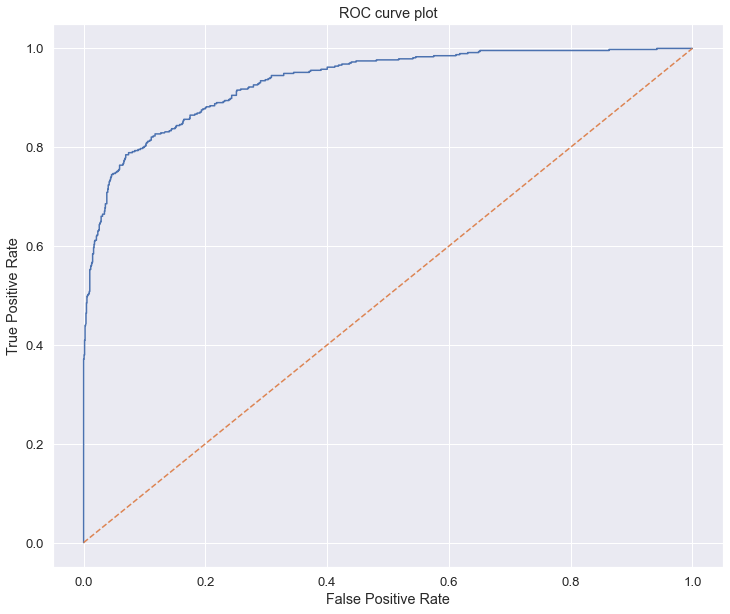

In [107]:
#fpr, tpr, thresholds = roc_curve(target_test_rf, y_pred_cb_test[:, 1])
fpr, tpr, thresholds = roc_curve(target_test_rf, y_pred_cb_test)
plt.figure(figsize=(12, 10))
plt.plot(fpr, tpr)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve plot')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

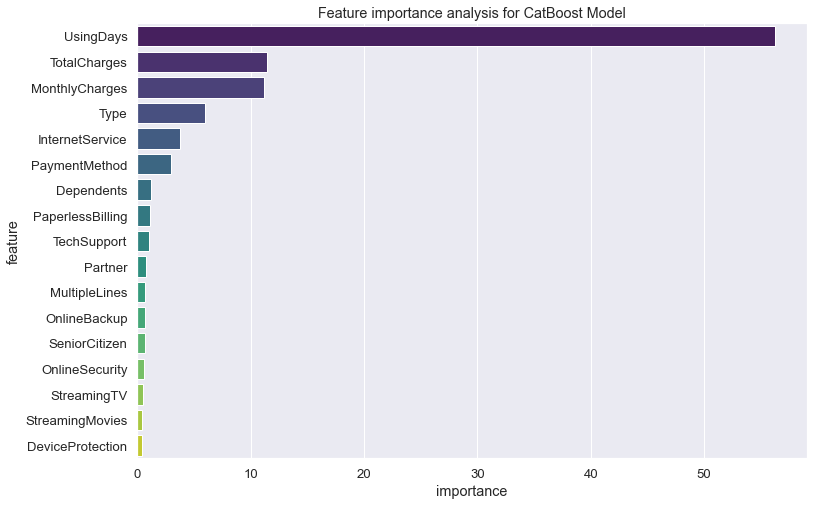

In [108]:
importances = grid_search_catboost.best_estimator_.feature_importances_


feature_importances = pd.DataFrame({'feature': features_train_rf.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Feature importance analysis for CatBoost Model')
plt.show()

<b>According to the feature importance analysis for the CatBoost model, the most significant features that strongly affect the result are 'UsingDays', 'TotalCharges', and 'MonthlyCharges'.</b>

In [109]:
#y_pred_cb_test_binary = np.round(y_pred_cb_test[:, 1]).astype(int)
y_pred_cb_test_binary = np.round(y_pred_cb_test).astype(int)
report = classification_report(target_test_rf, y_pred_cb_test_binary, output_dict=True)
report_end = pd.DataFrame(report).transpose()
report_end

,precision,recall,f1-score,support
0,0.899563,0.960373,0.928974,1287.000000
1,0.868217,0.708861,0.780488,474.000000
accuracy,0.892675,0.892675,0.892675,0.892675
macro avg,0.883890,0.834617,0.854731,1761.000000
weighted avg,0.891126,0.892675,0.889007,1761.000000


<b>Based on precision, recall, and f1-score metrics, it can be concluded that the CatBoost model accurately predicts the "0" class, as well as has good generalization ability (as evidenced by the accuracy metric value of 0.893 on the test set). However, the model less accurately identifies the "1" class.</b>